## Efficient iToF Simulation

In this notebook we want to confirm the following identity. Let $\alpha$, $l$, and $d$ be $nx1$ vectors, and let $\ast$ and $\star$ be the circular convolution and circular correlation operators, and $\cdot$ be the dot product operator

\begin{align*}
(\alpha \ast l)^t \cdot d = \alpha^t \cdot (l \star d) \\
\end{align*}

This identity is important for the simulation of indirect time-of-flight systems. If $\alpha$ is the impulse reponse of a pixel, and $l$ is the periodic light signal, then the incident signal on the sensor will be $\alpha \ast l$. This signal is multiplied and integrated with the sensor demodulation function $d$.

Usually, $l$ and $d$ are constant throughout the simulation, and if we have to do $\alpha \ast l$ for every single pixel, then it can become quite computationally expensive. 

Instead, what we want to do is to pre-compute $l \star d$, and then simply do the dot product $\alpha \cdot (l \star d)$. Doing the dot product for every pixel is much less computationally and memory intensive.

Even if $l$ and $d$ were constantly changing (e.g., we are optimizing them). As long as they are contant for more than a few pixels, before they are updated,  it is still worth it to just pre-compute $l \star d$ 

mu=3.497353439745747, sigma=0.5523679390927109
mu=0.4380670730582363, sigma=0.05649217558902725, explambda=5.310469934499575
mu=5.278933466953311, sigma=0.3138454199390403, explambda=2.450986123615188
mu=0.672771221842054, sigma=0.16947652676708175, explambda=31.862819606997444
mu=6.099332281410226, sigma=0.1318150763743969


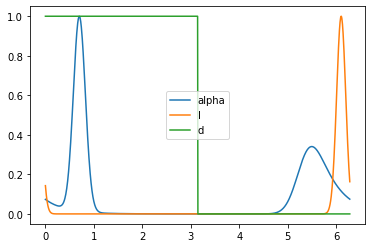

In [3]:
%matplotlib inline

## Standard Library Imports
import sys
sys.path.append('..')
## Library Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Local Imports
from research_utils.signalproc_ops import standardize_signal, circular_conv, circular_corr, normalize_signal, expgaussian_pulse_conv, gaussian_pulse

def get_random_delta(n):
    delta_f = np.zeros((n,))
    delta_f[int(np.round(n*np.random.rand()))] = 1.
    return delta_f
def get_random_gaussian(t, tau, dt):
    n=t.shape[-1]
    (mu, sigma)=(tau*np.random.rand(), dt*np.random.randint(low=1,high=int(n/10.)))
    print('mu={}, sigma={}'.format(mu,sigma))
    return gaussian_pulse(t, mu=mu, width=sigma)
def get_random_expmodgauss(t, tau, dt):
    n=t.shape[-1]
    (mu, sigma)=(tau*np.random.rand(), dt*np.random.randint(low=1,high=int(n/10.)))
    exp_lambda = 1. / (dt*np.random.randint(low=1,high=int(n/10.)))
    print('mu={}, sigma={}, explambda={}'.format(mu,sigma,exp_lambda))
    return expgaussian_pulse_conv(t, mu=mu, sigma=sigma, exp_lambda=exp_lambda)
    
## Initialize domain vairables
n = 1001
tau = 2*np.pi
dt = tau / n
t = np.arange(0,n)*dt

## Initialize alpha
## Delta pulse for alpha
alpha = get_random_delta(n)
# ## Gaussian Pulse
alpha = get_random_gaussian(t, tau, dt)
# ## Exp-Modified Gaussian Pulse
alpha = get_random_expmodgauss(t, tau, dt)
## Dual Exp-Modified Gaussian Pulse
alpha = get_random_expmodgauss(t, tau, dt) + get_random_expmodgauss(t, tau, dt)


# Initialize l and d
l = signal.square(t, duty=0.5)
l = get_random_gaussian(t, tau, dt)

d = signal.square(t, duty=0.5)

# Make all signals between 0-1 to visualize the easily
alpha = standardize_signal(alpha)
l = standardize_signal(l)
d = standardize_signal(d)
## Visualize Signal
plt.plot(t, alpha, label='alpha')
plt.plot(t, l, label='l')
plt.plot(t,d, label='d')
plt.legend()




alpha_conv_l_dot_d = 1929.2492524625961
l_conv_alpha_dot_d = 1929.2492524625961
alpha_dot_l_corr_d = 1929.2492524625968
alpha_dot_d_corr_l = 1528.487791042979


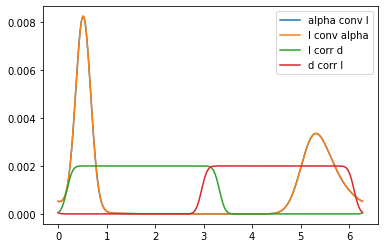

In [4]:
alpha_conv_l = circular_conv(alpha, l)
l_conv_alpha = circular_conv(l, alpha)
l_corr_d = circular_corr(l, d)
d_corr_l = circular_corr(d, l)

plt.plot(t, alpha_conv_l / alpha_conv_l.sum(axis=-1), label='alpha conv l')
plt.plot(t, l_conv_alpha / l_conv_alpha.sum(axis=-1), label='l conv alpha')
plt.plot(t, l_corr_d / l_corr_d.sum(axis=-1), label='l corr d')
plt.plot(t, d_corr_l / d_corr_l.sum(axis=-1), label='d corr l')
plt.legend()

alpha_conv_l_dot_d = np.dot(alpha_conv_l, d)
print("alpha_conv_l_dot_d = {}".format(alpha_conv_l_dot_d))

l_conv_alpha_dot_d = np.dot(l_conv_alpha, d)
print("l_conv_alpha_dot_d = {}".format(l_conv_alpha_dot_d))

alpha_dot_l_corr_d = np.dot(alpha, l_corr_d)
print("alpha_dot_l_corr_d = {}".format(alpha_dot_l_corr_d))

alpha_dot_d_corr_l = np.dot(alpha, d_corr_l)
print("alpha_dot_d_corr_l = {}".format(alpha_dot_d_corr_l))


The above simulation seems to confirm the identify. 

**Important Note:**  As shown above, since **correlation is NOT commutative** that means we cannot flip the order of $l$ and $d$. In other words,

\begin{align*}
(\alpha \ast l)^t \cdot d \neq \alpha^t \cdot (d \star l) \\
(\alpha \ast l)^t \cdot d = \alpha^t \cdot (l \star d)
\end{align*}